**KMeans clustering for finding out SQL injection anamolies from dump of server log**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.parse

df = pd.read_excel('/content/gdrive/MyDrive/Datasets/Security/server_log.xlsx')
df.head()

,requests
0,INFO:werkzeug:127.0.0.1 - - [26/Nov/2021 21:12...
1,INFO:werkzeug:127.0.0.1 - - [26/Nov/2021 21:12...
2,INFO:werkzeug:127.0.0.1 - - [26/Nov/2021 21:12...
3,INFO:werkzeug:127.0.0.1 - - [26/Nov/2021 21:12...
4,INFO:werkzeug:127.0.0.1 - - [26/Nov/2021 21:12...


In [ ]:
df.shape

(67963, 1)

In [ ]:
df = df[:20000]
df.shape

(20000, 1)

In [ ]:
# Removing the timestamp from request
import re
df['requests'] = df['requests'].apply(lambda ele: re.sub('^INFO[\s\S]*(])', '', ele))

# Removing the special white space characters
df['requests'] = df['requests'].apply(lambda ele: ele.replace('%20', ' '))

# Removing the response string HTTP/1.1" 200
df['requests'] = df['requests'].apply(lambda ele: ele.replace('HTTP/1.1" 200', ''))

In [ ]:
# Converting the strings into vectorizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words=stopwords.words('english'))
queries = vectorizer.fit_transform(df['requests'].values.astype('U')).toarray()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
words = []
for key in vectorizer.vocabulary_:
    words.append(key)

In [ ]:
new_df = pd.DataFrame(queries)
new_df = new_df.T
new_df.index = words
new_df = new_df.T
new_df.head()

,get,sql,inject,01450,6203,4747,dbms_utility,sqlid_to_sqlhash,chr,113,7c,7cchr,112,106,select,case,else,end,dual,122,118,luee,jsica,cortegana,1610,20285,207,26260,imgv,7802,14790,9297,union,6841,7967,57186589x,12195,18833,qui0g6n16si2o,1031,...,9295,deliverance,10011,1787,transmissions,downloading,sending,17798,15169,8735,10002,22149,13233,28435,30802142j,37254,10847,02005072r,ysij,6140,jean,yve,nesserin,fnpq,5209,20724,29061025l,torcuarto,5310,8229,14952,01632755p,26882,blotta,cecil,wolcott7,tricentenario,8306,17402,7383
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3)
y_preds = km.fit_predict(new_df)

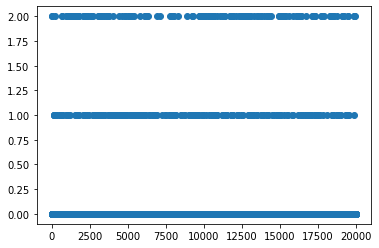

In [ ]:
plt.scatter(range(20000), y_preds)
plt.show()

In [ ]:
clustered_df = new_df
clustered_df['cluster_id'] = y_preds
clustered_df.head()

,get,sql,inject,01450,6203,4747,dbms_utility,sqlid_to_sqlhash,chr,113,7c,7cchr,112,106,select,case,else,end,dual,122,118,luee,jsica,cortegana,1610,20285,207,26260,imgv,7802,14790,9297,union,6841,7967,57186589x,12195,18833,qui0g6n16si2o,1031,...,deliverance,10011,1787,transmissions,downloading,sending,17798,15169,8735,10002,22149,13233,28435,30802142j,37254,10847,02005072r,ysij,6140,jean,yve,nesserin,fnpq,5209,20724,29061025l,torcuarto,5310,8229,14952,01632755p,26882,blotta,cecil,wolcott7,tricentenario,8306,17402,7383,cluster_id
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df['cluster_id'] = y_preds
df.head()

,requests,cluster_id
0,"""GET /sql-inject/?q=01450 -",0
1,"""GET /sql-inject/?q=-6203' ) ) ) or 4747...",2
2,"""GET /sql-inject/?q=jsica -",0
3,"""GET /sql-inject/?q=cortegana -",0
4,"""GET /sql-inject/?q=1610 -",0


In [ ]:
file_name = '/content/gdrive/MyDrive/Models/1-cluster.xlsx'
df[df['cluster_id'] == 1].to_excel(file_name)

file_name = '/content/gdrive/MyDrive/Models/2-cluster.xlsx'
df[df['cluster_id'] == 2].to_excel(file_name)

file_name = '/content/gdrive/MyDrive/Models/0-cluster.xlsx'
df[df['cluster_id'] == 0].to_excel(file_name)

In [ ]:
# Loading the SQL Injection Model
# Fetching the model
import pickle
import os
save_location = '/content/gdrive/MyDrive/Models/Security Models'
model_name = 'sql_inject_model.sav'
fetch_model = pickle.load(open(os.path.join(save_location, model_name), 'rb'))
model = fetch_model['model']
vectorizer = fetch_model['vectorizer']

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:333: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.22.2.post1 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:333: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.22.2.post1 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [ ]:
import numpy as np
test_corpus = df[df['cluster_id'] == 0].requests.values
test_query = vectorizer.transform(test_corpus).toarray()
test_prediction = model.predict(test_query)
len(test_prediction) - sum(test_prediction == 1)

17112

In [ ]:
test_corpus = df[df['cluster_id'] == 1].requests.values
test_query = vectorizer.transform(test_corpus).toarray()
test_prediction = model.predict(test_query)
len(test_prediction) - sum(test_prediction == 1) 

0

In [ ]:
test_corpus = df[df['cluster_id'] == 2].requests.values
test_query = vectorizer.transform(test_corpus).toarray()
test_prediction = model.predict(test_query)
len(test_prediction) - sum(test_prediction == 1)

0